## Import datas

In [109]:
import pandas as pd
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from scipy import stats

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [110]:
# Use pandas to loadinto a DataFrame
# Y1.csv doesn’t have a header so
# add one when loading the file
X1 = pd.read_csv("data/X1.csv")
Y1 = pd.read_csv("data/Y1.csv", header=None, names=['revenue'])


# ENLEVER colonne "Unnamed" du dataset : utilité ? -> Pas listé dans les features du pdf
X = X1.drop(['Unnamed: 0', 'img_url', 'description'], axis=1)

### Pre data visualisation

           ratings       n_votes  is_adult  production_year  release_year
count  4012.000000  4.012000e+03    4012.0      4012.000000   4012.000000
mean      6.530409  2.260019e+04       0.0      1997.395563   2000.056082
std       1.208409  9.956869e+04       0.0        12.066252     10.245970
min       1.900000  5.000000e+00       0.0      1916.000000   1921.000000
25%       5.800000  8.275000e+01       0.0      1992.000000   1994.000000
50%       6.600000  9.000000e+02       0.0      2001.000000   2002.000000
75%       7.300000  7.195750e+03       0.0      2006.000000   2007.000000
max      10.000000  2.369294e+06       0.0      2021.000000   2018.000000


C:\Users\robip\AppData\Local\Temp\ipykernel_15932\267632109.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = X.corr()


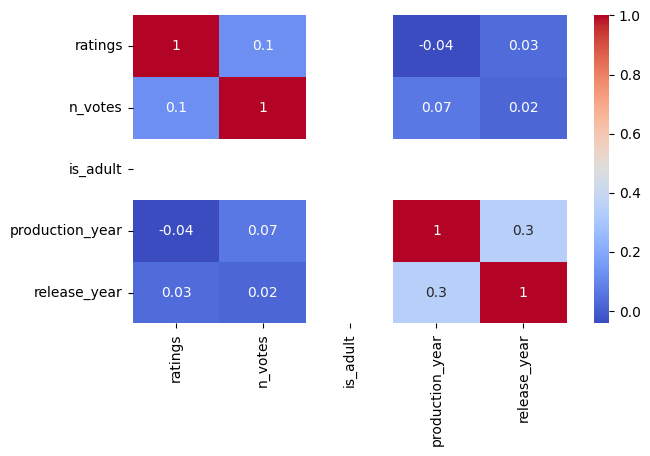

In [111]:
print(X.describe())

plt.figure(figsize=(7,4))
corr = X.corr()
heatmap = sns.heatmap(corr, annot=True, cmap="coolwarm", fmt='.1g')

## Preprocessing the data

In [112]:
"""
Creating empty DataFrame to start
"""
n_samples = X.shape[0]
data = pd.DataFrame()

In [113]:
"""
Keeping the directly usable features
"""

directly_usable_features = ["ratings", "n_votes", "is_adult"]
for feature in directly_usable_features:
    data[feature] = X[feature]

In [114]:
"""
Dealing with the "production_year" feature
"""

n_year_period = 5 # n_year_period categorical features for each computed period
style = "per_quantile"
# style = "per_period_length"
# style = "no_period"


# Removing previously computed categorie(s) for the "production_year" initial feature

for feature in data.columns:
    if len(feature) >= 8 and (feature[:6] == "period" or feature == "production_year"):
        data.drop(feature, axis=1, inplace=True)

# Creating new categorie(s) for the "production_year" initial feature

prod_year = X["production_year"].copy()
if style == "per_quantile" or style == "per_period_length":
    categories = np.ones((n_year_period, n_samples))
    
    if style == "per_quantile":
        thresholds = prod_year.quantile(np.arange(1, n_year_period) / n_year_period)
    else :
        thresholds = np.min(prod_year) + (np.max(prod_year) - np.min(prod_year))*np.arange(1, n_year_period)/n_year_period
    for i, threshold in enumerate(thresholds):
        categories[i+1] = (prod_year >= threshold).astype(int)
        categories[i] -= categories[i+1]
    for period in range(n_year_period):
        data["period {}".format(period)] = categories[period]
elif style == "no_period":
    data["production_year"] = prod_year

In [115]:
"""
Dealing with the "runtime" feature

The problem is here that we have some missing values, we have to deal with it.
"""

# Add other smarter ways ?

# replace_type = "zero"
replace_type = "mean"

runtime = X["runtime"].copy()
if replace_type == "zero":
    runtime[runtime == "\\N"] = 0
if replace_type == "mean":
    mean = np.mean(runtime[runtime != "\\N"].astype(float))
    runtime[runtime == "\\N"] = mean
data["runtime"] = runtime.astype(float)    

In [116]:
"""
Dealing with the "studio" feature


Juste rajouter toute les features une par une me semblait un peu lourd (yen a 509), ducoup j'effectue PCA dessus.
Jsp si ça se fait ? (on peut changer l'algo de dimensionality reduction aussi si on veut)
"""

use_PCA = True
dim = 20 # output dimension of vectors created by PCA if PCA is used


# Removing previously computed categorie(s) for the "studio" initial feature
for feature in data.columns:
    if len(feature) >= 10 and feature[:10] == "studio_PC_":
        data.drop(feature, axis=1, inplace=True)

# Creating new categorie(s) for the "studio" initial feature
studio = X["studio"].copy()
studio_labels = np.unique(studio)
studio_features = np.zeros((len(studio_labels), n_samples))
for i, label in enumerate(studio_labels) :
    studio_features[i] = (studio == label).astype(int)

# Applying pca or not
if use_PCA :
    pca = PCA(n_components=dim)
    out = pca.fit_transform(studio_features.T)
else :
    out = studio_features.T
    
data[["studio_PC_{}".format(i) for i in range(dim)]] = out

# Ya plein de warnings quand dim trop grand ou pas de PCA /: 
# jsp comment regler ça... en utilisant pd.concat ça tourne vraiment extrêmement lentement

In [117]:
"""
Dealing with the "genres" feature

Je rajoute juste une feature par genre, j'espère ça suffit ? -> pt-être dimension reduction sur ça aussi ?
Certains films ont pas de genre attitré (genre = "\\N"),
ce que j'ai fait ici considère ça comme un genre à part entière, ptet on peut deal le truc autrement ?
"""

X.loc[X["genres"] == "\\N", "genres"] = "Others"
all_genres = X["genres"].copy()
diff_genres = []


for genres in np.unique(all_genres):
    for genre in genres.split(",") :
        if not genre in diff_genres :
            diff_genres.append(genre)
            
for genre in diff_genres:
    data[genre] = [1 if genre in genres.split(",") else 0 for genres in all_genres]

In [118]:
"""
Dealing with the "text_embeddings" feature


Dimension of embedding space is too high -> dimensionnality reduction
J'utilise que PCA pr l'instant ici aussi
"""

output_dim = 20 # output dimension of PCA


# Removing previously computed categorie(s) for the "text_embedding" initial feature
for feature in data.columns:
    if len(feature) >= 18 and feature[:18] == "text_embedding_PC_":
        data.drop(feature, axis=1, inplace=True)

# Creating new categorie(s) for the "text_embedding" initial feature
text_embeddings = X["text_embeddings"]
input_dim = 768
embeddings = np.zeros((n_samples, input_dim))
for i, text_embedding in enumerate(text_embeddings):
    embeddings[i] = list(map(float,text_embedding[1:-1].split(",")))

# applying PCA
pca = PCA(n_components=output_dim)
output = pca.fit_transform(embeddings)

data[["text_embedding_PC_{}".format(i) for i in range(output_dim)]] = output

In [119]:
"""
Dealing with the "img_embeddings" feature


Dimension of embedding space is too high -> dimensionnality reduction
J'utilise que PCA pr l'instant ici aussi
"""

output_dim = 20 # output dimension of PCA


# Removing previously computed categorie(s) for the "img_embedding" initial feature
for feature in data.columns:
    if len(feature) >= 17 and feature[:17] == "img_embedding_PC_":
        data.drop(feature, axis=1, inplace=True)

# Creating new categorie(s) for the "img_embedding" initial feature
img_embeddings = X["img_embeddings"]
input_dim = 2048
embeddings = np.zeros((n_samples, input_dim))
for i, img_embedding in enumerate(img_embeddings):
    embeddings[i] = list(map(float,img_embedding[1:-1].split(",")))

# applying PCA
pca = PCA(n_components=output_dim)
output = pca.fit_transform(embeddings)

data[["img_embedding_PC_{}".format(i) for i in range(output_dim)]] = output

### Data visualisation

In [120]:
data.head()


,ratings,n_votes,is_adult,period 0,period 1,period 2,period 3,period 4,runtime,studio_PC_0,...,img_embedding_PC_10,img_embedding_PC_11,img_embedding_PC_12,img_embedding_PC_13,img_embedding_PC_14,img_embedding_PC_15,img_embedding_PC_16,img_embedding_PC_17,img_embedding_PC_18,img_embedding_PC_19
0,6.2,33519.0,0,0.0,1.0,0.0,0.0,0.0,104.000000,0.942714,...,0.579684,0.392696,0.283097,0.074624,0.482119,0.824742,-1.807539,3.294237,2.681085,-0.321545
1,7.7,647.0,0,0.0,0.0,0.0,1.0,0.0,118.000000,-0.036620,...,3.272713,-0.569320,1.744748,-2.906756,1.714369,1.539246,0.481626,-2.589841,-3.043259,-0.436896
2,5.8,43497.0,0,0.0,0.0,0.0,0.0,1.0,119.000000,-0.186940,...,-0.674918,-1.232762,1.224191,-1.152338,-2.918860,-0.305285,-2.395634,1.283079,1.397721,-0.568742
3,7.7,16.0,0,1.0,0.0,0.0,0.0,0.0,30.000000,-0.035555,...,0.662748,-4.217336,-0.693091,0.737908,-1.968343,-0.738703,-0.741666,0.020150,-1.030051,0.532160
4,5.7,7.0,0,0.0,0.0,0.0,1.0,0.0,88.304408,-0.034550,...,-4.109129,1.037271,-0.510560,-3.766999,-0.980945,0.270259,1.376293,1.315463,0.355035,-2.690206


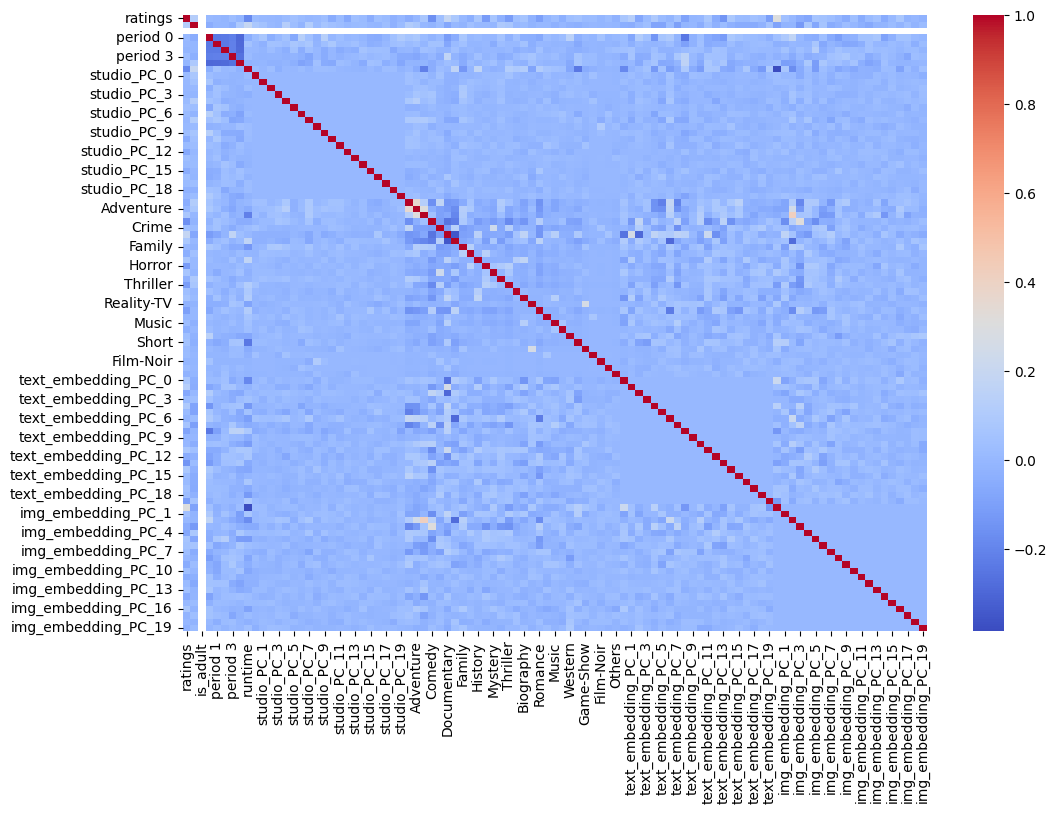

In [121]:
plt.figure(figsize=(12,8))
corr = data.corr()
heatmap = sns.heatmap(corr, cmap="coolwarm")

### Feature Selection


In [81]:
# Creer un data training/validation splités a partir du X1 (on garde X2 pour les vrais tests) 
X_train, X_test, y_train, y_test = train_test_split(data, Y1, test_size = 0.2, random_state=1)

In [82]:
# Score computation : Root Mean Square Error
def compute_rmse(predict, target):
    if len(target.shape) == 2:
        target = target.squeeze()
    if len(predict.shape) == 2:
        predict = predict.squeeze()
    diff = target - predict
    if len(diff.shape) == 1:
        diff = np.expand_dims(diff, axis=-1)
    rmse = np.sqrt(diff.T@diff / diff.shape[0])
    return float(rmse)

In [83]:
from sklearn.feature_selection import mutual_info_regression
scores = mutual_info_regression(X_train, y_train)

scores.mean()

C:\Users\robip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.11447781759641365

### Linear Regression

In [84]:
def fit_predict_with_features(X_train,Y_train, X_test, Y_test, selected_features):
    X_train_filtered = X_train[selected_features]
    X_test_filtered = X_test[selected_features]
    
    clf = LinearRegression(n_jobs=-1)
    clf.fit(X_train_filtered,Y_train)
    print(clf.score(X_test_filtered, Y_test))
    y_pred = clf.predict(X_test_filtered)

    return y_pred

In [85]:
print('By selecting features')
# Dans ce cas, on selectionne tout
Y_pred = fit_predict_with_features(X_train,y_train, X_test, y_test, X_train.columns)


By selecting features
0.3043717912485657


### GridSearch on KNN

In [86]:
def perform_grid_search(model_, params, scoring,X_train, y_train):

    clf = GridSearchCV(model_, params, cv=5, scoring=scoring, n_jobs=-1)
    grid_result = clf.fit(X_train,y_train)
    print("clf.best_score_: ", clf.best_score_)
    print("clf.best_params_: ",clf.best_params_)
    return grid_result
 
 
# Définir les valeurs à tester pour les hyperparamètres du modèle
params =    {'n_neighbors' : range(3, 40), 
            'weights' : ['uniform', 'distance']}
knn = KNeighborsRegressor(n_jobs=-1)
scoring = "neg_mean_squared_error"

grid = perform_grid_search(knn, params, scoring, X_train, y_train)
pred = grid.best_estimator_.predict(X_test)
print("pred: ",pred.mean())

print("Score")
model = grid.best_estimator_
print(model.score(X_test,y_test))
rmse = compute_rmse(pred, y_test)
rmse

clf.best_score_:  -5250729802633909.0
clf.best_params_:  {'n_neighbors': 39, 'weights': 'uniform'}
pred:  31442528.489427075
Score
0.10308097499160929


94457941.2974856

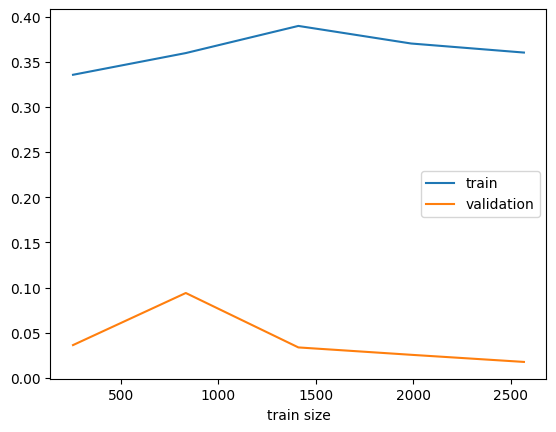

In [91]:
# Score for each training subset
N, train_score, val_score = learning_curve(knn, X_train, y_train, cv=5)

plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.xlabel("train size")
plt.legend()

In [92]:
# Evaluation metrics from the gridsearch
res = pd.DataFrame(grid.cv_results_.values(), ).transpose()
res.columns=grid.cv_results_.keys()
res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.029519,0.005873,0.080985,0.007362,3,uniform,"{'n_neighbors': 3, 'weights': 'uniform'}",-5703473775706155.0,-6956608036873706.0,-6233617332025815.0,-8478971624226779.0,-6674820290301200.0,-6809498211826731.0,936146330324331.75,73
1,0.044269,0.015863,0.114694,0.036904,3,distance,"{'n_neighbors': 3, 'weights': 'distance'}",-5652452487288047.0,-6674735938672613.0,-6326910708601936.0,-9274123558565064.0,-6587140122250564.0,-6903072563075645.0,1238535167117542.0,74
2,0.034913,0.006707,0.100923,0.016836,4,uniform,"{'n_neighbors': 4, 'weights': 'uniform'}",-5133382495944383.0,-6395562395046488.0,-5874536353162055.0,-8227161776826572.0,-6277330588154648.0,-6381594721826830.0,1022968798159689.5,71
3,0.043884,0.007849,0.091754,0.021466,4,distance,"{'n_neighbors': 4, 'weights': 'distance'}",-5210019376525486.0,-6163452812516648.0,-5919671406205021.0,-8872447232748104.0,-6237586084658865.0,-6480635382530825.0,1249766961333901.75,72
4,0.036302,0.004487,0.085572,0.003534,5,uniform,"{'n_neighbors': 5, 'weights': 'uniform'}",-4952053064255883.0,-5944774005875243.0,-5705022742549813.0,-7850064909207073.0,-6226727808768404.0,-6135728506131283.0,956063680268269.0,69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,0.033113,0.006257,0.082183,0.01445,37,distance,"{'n_neighbors': 37, 'weights': 'distance'}",-4366738617371093.0,-4789374667812471.0,-4844757013649510.0,-7584154797812567.0,-5430314877061064.0,-5403067994741341.0,1141944943038232.5,26
70,0.027328,0.003816,0.083578,0.016304,38,uniform,"{'n_neighbors': 38, 'weights': 'uniform'}",-4173656048565541.5,-4874472672875750.0,-4571481285165299.0,-7111813641456874.0,-5543168524562430.0,-5254918434525179.0,1030737753835153.375,2
71,0.028723,0.008814,0.078591,0.012756,38,distance,"{'n_neighbors': 38, 'weights': 'distance'}",-4364724986431786.5,-4773037244345246.0,-4848025927856267.0,-7584058722901703.0,-5428628044391686.0,-5399694985185338.0,1143720563062003.25,25
72,0.03689,0.006994,0.081585,0.013868,39,uniform,"{'n_neighbors': 39, 'weights': 'uniform'}",-4174735592493202.5,-4865615644059464.0,-4554521409184085.0,-7118065081776189.0,-5540711285656605.0,-5250729802633909.0,1035549408548547.125,1
